# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [44 lines of output]
  Traceback (most recent call last):
    File "C:\Users\Bharat singh parihar\.conda\envs\my-env\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
      parsed = _parse_requirement(requirement_string)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\Bharat singh parihar\.conda\envs\my-env\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
      return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\Bharat singh parihar\.conda\envs\my-env\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
      url, specifier, marker = _parse_requirement_details(tokenizer)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [2]:
!pip list

Package                      Version
---------------------------- --------
absl-py                      2.1.0
anyio                        4.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.11.0
beautifulsoup4               4.12.2
bleach                       4.1.0
Brotli                       1.0.9
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           2.0.4
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.1
executing                    0.8.3
fastjsonschema               2.16.2
flatbuffers                  24.3.25
fonttools                    4.51.0
f

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

C:\Users\Bharat singh parihar\AppData\Local\Temp\ipykernel_7452\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image data\happy\.ipynb_checkpoints


# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 306 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

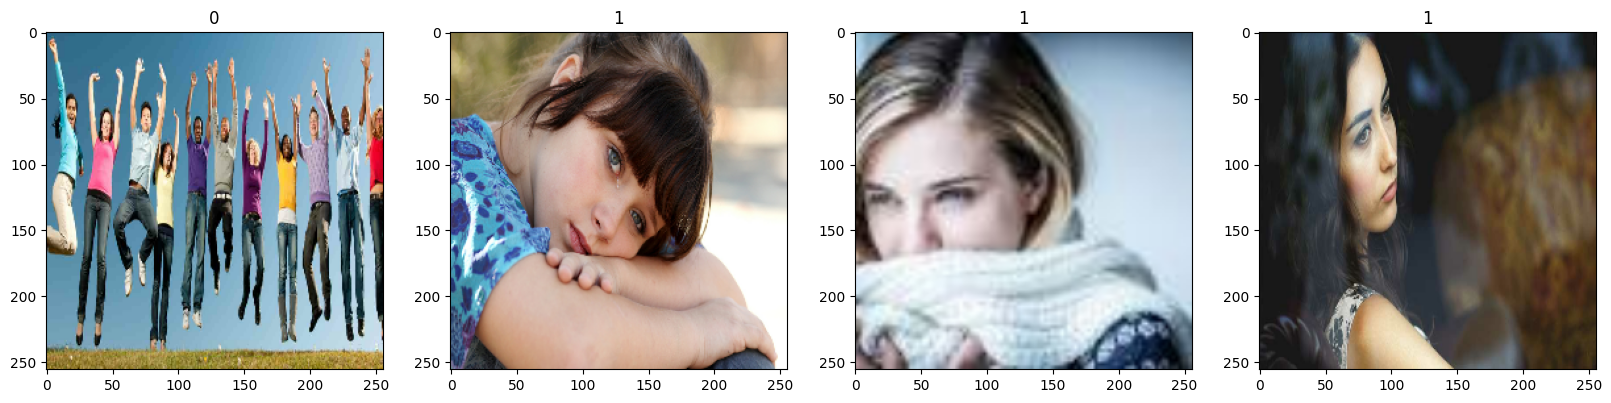

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.2784314 , 0.43137255, 0.45882353],
          [0.2784314 , 0.43137255, 0.45882353],
          [0.2784314 , 0.43137255, 0.45882353],
          ...,
          [0.33333334, 0.46666667, 0.5058824 ],
          [0.3354703 , 0.46595436, 0.5058824 ],
          [0.34509805, 0.4627451 , 0.5058824 ]],
 
         [[0.2784314 , 0.43137255, 0.45882353],
          [0.2784314 , 0.43137255, 0.45882353],
          [0.2784314 , 0.43137255, 0.45882353],
          ...,
          [0.33012408, 0.4634574 , 0.5026731 ],
          [0.33109516, 0.4627451 , 0.5026731 ],
          [0.3354703 , 0.45953584, 0.5026731 ]],
 
         [[0.2784314 , 0.43137255, 0.45882353],
          [0.2784314 , 0.43137255, 0.45882353],
          [0.2784314 , 0.43137255, 0.45882353],
          ...,
          [0.32941177, 0.4627451 , 0.5019608 ],
          [0.33012408, 0.4620328 , 0.5019608 ],
          [0.33333334, 0.45882353, 0.5019608 ]],
 
         ...,
 
         [[0.02543658, 0.06857383, 0.09210325],
          [0.02193

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

7

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\Bharat singh parihar\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - accuracy: 0.4878 - loss: 1.1429 - val_accuracy: 0.4219 - val_loss: 0.7261
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.5890 - loss: 0.6804 - val_accuracy: 0.6406 - val_loss: 0.6285
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.6343 - loss: 0.6394 - val_accuracy: 0.6562 - val_loss: 0.5840
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.6450 - loss: 0.6075 - val_accuracy: 0.7812 - val_loss: 0.5899
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.7899 - loss: 0.5494 - val_accuracy: 0.7656 - val_loss: 0.4564
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.8256 - loss: 0.3987 - val_accuracy: 0.8750 - val_loss: 0.3375
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.8635 - loss: 0.3329 - val_accuracy: 0.9062 - val_loss: 0.2619
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.8909 - loss: 0.2945 - val_accuracy: 0.9375 - val_loss:

# 8. Plot Performance

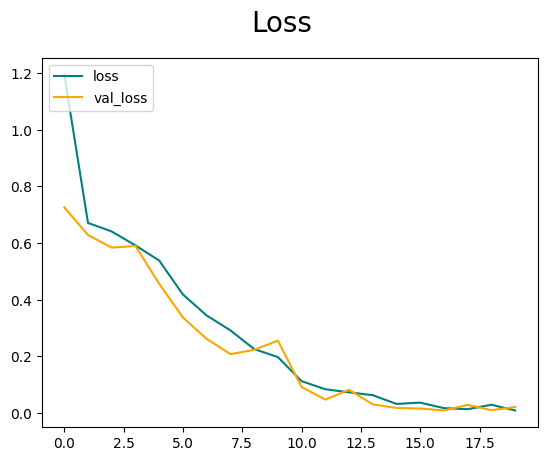

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

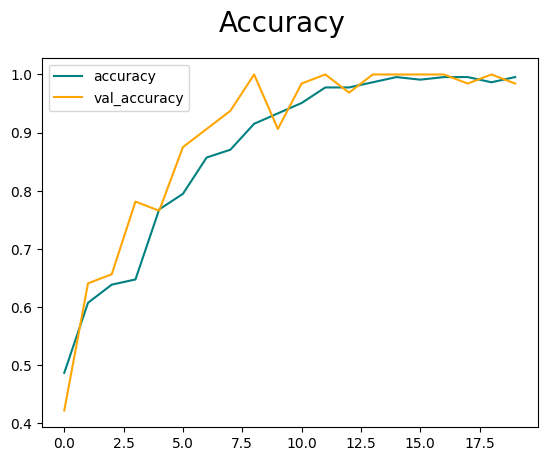

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

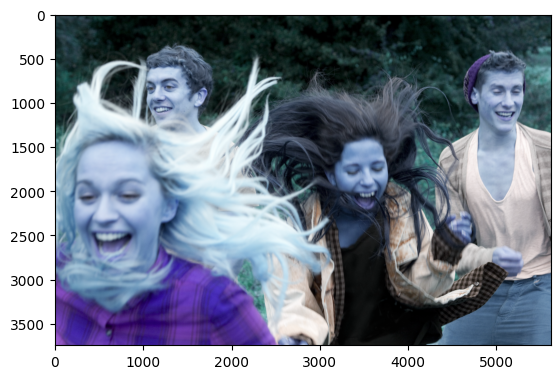

In [36]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

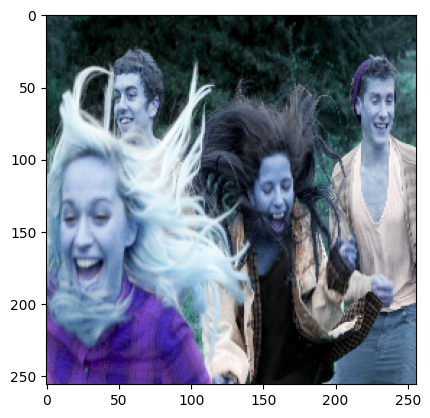

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [39]:
yhat

array([[1.1128113e-05]], dtype=float32)

In [40]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('models','imageclassifier.h5'))

In [43]:
new_model = load_model('imageclassifier.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'imageclassifier.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [44]:
new_model.predict(np.expand_dims(resize/255, 0))

NameError: name 'new_model' is not defined